In [32]:
%matplotlib inline

## API

In [58]:
import os
import datetime
import quandl

import matplotlib.pyplot as plt
import pandas as pd
import quandl
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [34]:
path = r"E:\UChicago MSFM\Lectures\FINM33150\HW"
api_key = 'VGcKQuaiTp_m8uzatRSR'

def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(path, "quandl_data_table_downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.makedirs(table_dir, exist_ok=True)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key=api_key, **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )

## Data

In [35]:
t_ivm = fetch_quandl_table('AR/IVM', avoid_download=True)
display(t_ivm.head())

t_ivm.columns

t_ivm = t_ivm[['exchange_code', 'futures_code', 'option_code', 'expiration', 
               'date', 'futures', 'atm', 'days_expiration', 'days_termination']]

Skipping any possible download of AR/IVM


,exchange_code,futures_code,option_code,expiration,date,futures,atm,rr25,rr10,fly25,...,beta1,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination
0,CBT,BO,BO,1M,2024-12-16,41.731864,0.302640,0.017717,0.028022,0.008861,...,0.136273,2.253584,-4.503889,-12.900171,33.798866,123.711572,-0.208212,0.237649,31.0,31.0
1,CBT,BO,BO,1W,2024-12-16,41.589492,0.275612,-0.009755,-0.026915,0.008703,...,-0.184783,12.724505,-9.970579,-380.836794,172.546492,3543.441557,-0.105488,0.089992,7.0,7.0
2,CBT,BO,BO,1Y,2024-12-16,42.360909,0.280757,0.027657,0.056929,0.003687,...,0.080256,-0.029207,-0.342699,1.571995,0.678517,-3.644149,-0.521268,0.535857,365.0,365.0
3,CBT,BO,BO,2M,2024-12-16,41.915763,0.329431,0.043624,0.072584,0.009547,...,0.234473,0.732446,-3.166721,3.916127,14.579110,-26.639620,-0.291922,0.406860,62.0,62.0
4,CBT,BO,BO,3M,2024-12-16,42.079836,0.331620,0.046527,0.078083,0.009520,...,0.207442,0.439917,-1.951898,2.573566,6.612833,-11.690214,-0.344729,0.488955,90.0,90.0


W, X (8): NYM.RB versus ICE.G × 0.0033

Y, Z (6): CBT.TU versus CBT.TY × 0.8978

In [36]:
start_date = "2021-12-03"
end_date = "2024-08-31"
t_ivm['date'] = pd.to_datetime(t_ivm['date'])

print(len(t_ivm))
t_ivm = t_ivm[(t_ivm['date'] >= start_date) & (t_ivm['date'] <= end_date)]
print(len(t_ivm))

5359464
1081652


In [37]:
nym_rb = t_ivm[(t_ivm['exchange_code'] == 'NYM') & (t_ivm['futures_code'] == 'RB')]

print(f"NYM.RB: {len(nym_rb)}")

ice_g = t_ivm[(t_ivm['exchange_code'] == 'ICE') & (t_ivm['futures_code'] == 'G')]
print(f"ICE.G: {len(ice_g)}")

cbt_tu = t_ivm[(t_ivm['exchange_code'] == 'CBT') & (t_ivm['futures_code'] == 'TU')]
print(f"CBT.TU: {len(cbt_tu)}")

cbt_ty = t_ivm[(t_ivm['exchange_code'] == 'CBT') & (t_ivm['futures_code'] == 'TY')]
print(f"CBT.TY: {len(cbt_ty)}")

NYM.RB: 14892
ICE.G: 26137
CBT.TU: 10937
CBT.TY: 11065


In [38]:
def data_filter(df, min_expiration=30):
    # This function is to maintain only the required contract
    df_filtered = df[df['days_expiration'] >= min_expiration].copy()
    def pick_min_in_group(g):
        idx = g['days_expiration'].idxmin()
        return g.loc[idx]

    df_result = df_filtered.groupby('date', as_index=False).apply(pick_min_in_group)
    df_result.reset_index(drop=True, inplace=True)

    return df_result

In [ ]:
nym_rb = data_filter(df = nym_rb)
print(f"NYM.RB: {len(nym_rb)}")

ice_g = data_filter(df = ice_g)
print(f"ICE.G: {len(ice_g)}")

cbt_tu = data_filter(df = cbt_tu)
print(f"CBT.TU: {len(cbt_tu)}")

cbt_ty = data_filter(df = cbt_ty)
print(f"CBT.TY: {len(cbt_ty)}")

# From the data summary above, we can see the length of ICE.G doesn't align with others, so we would like to ffill the data

NYM.RB: 715
ICE.G: 709
CBT.TU: 715
CBT.TY: 715


In [40]:
st_1 = (nym_rb['futures'] - ice_g['futures'] * 0.0033).ffill()
st_2 = (cbt_tu['futures'] - cbt_ty['futures'] * 0.8978).ffill()

print(st_1.isna().sum())
print(st_2.isna().sum())

st_1.index = nym_rb['date']
st_2.index = cbt_tu['date']

st_1.dropna(inplace=True)

print(len(st_1))

0
0
715


## Analysis

Descriptive Statistics for st_1:
Descriptive Statistics for st_2:


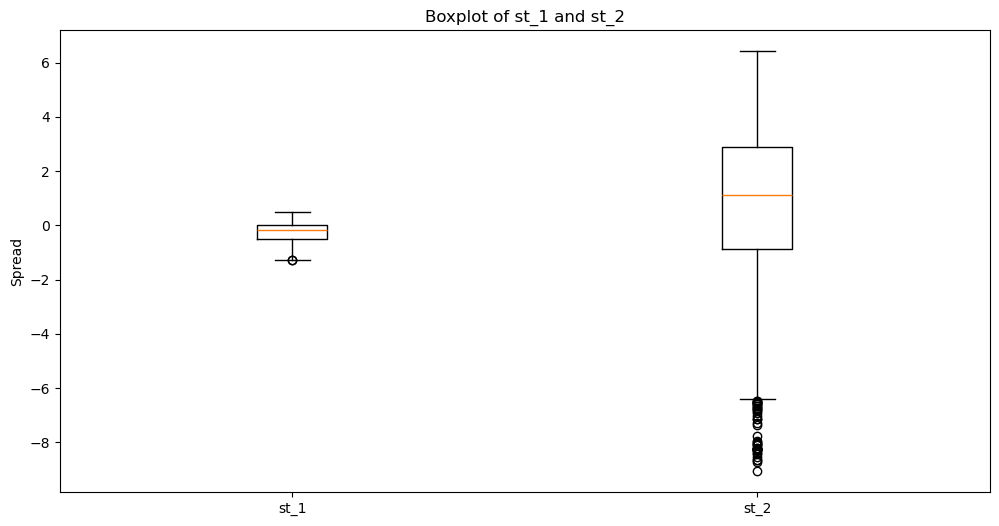

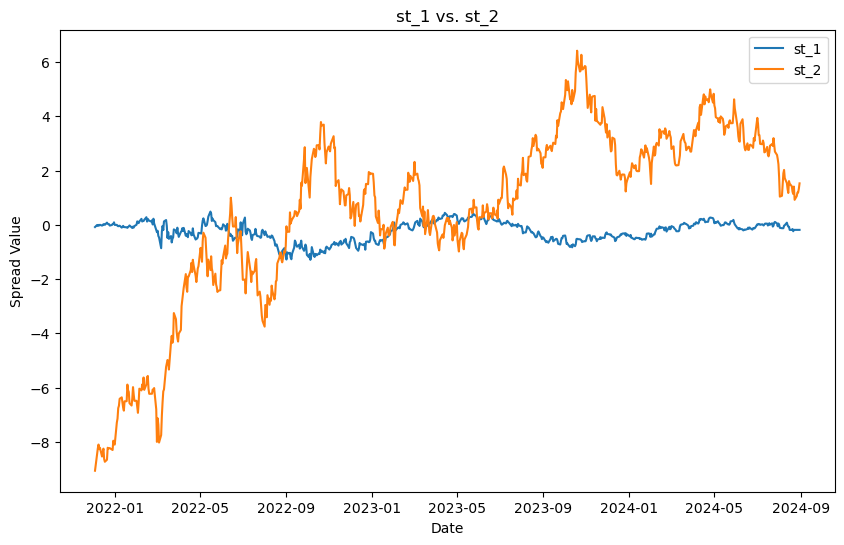

In [50]:
print("Descriptive Statistics for st_1:")
st_1.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

print("Descriptive Statistics for st_2:")
st_2.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

plt.figure(figsize=(12, 6))
plt.boxplot([st_1, st_2], labels=['st_1', 'st_2'])
plt.title('Boxplot of st_1 and st_2')
plt.ylabel('Spread')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(st_1, label='st_1')
plt.plot(st_2, label='st_2')
plt.legend()
plt.title("st_1 vs. st_2")
plt.xlabel("Date")
plt.ylabel("Spread Value")
plt.show()

From the descriptive analysis, we can see the volatility difference between these two spreads are quite significant. From the plot above, it seemes that the spread of st_1 is quite close to 0, but the spread for st_2 is much deviated. From the box plot, st_1 has more negative mean compared to st_2. Also, we can notice that st_2 has quite many negative outliers compared to st_2, which means that the distribution of st_2 is more left skewed.

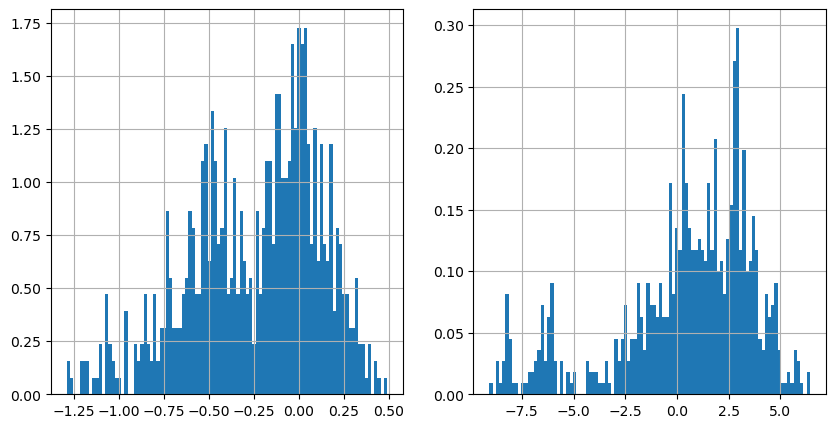

In [51]:
f, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(st_1, bins=100, density=True)
axs[0].grid(True)

axs[1].hist(st_2, bins=100, density=True)
axs[1].grid(True)
plt.show()

In [52]:
st_1.name = 'st_1'
st_2.name = 'st_2'

merged_series = pd.merge(st_1, st_2, on = 'date', how = 'left')
merged_series

correlation = merged_series['st_1'].corr(merged_series['st_2'])

print(f"The correlation of the two spread is {correlation}")

The correlation of the two spread is -0.19463185511886058


### Correlation Test

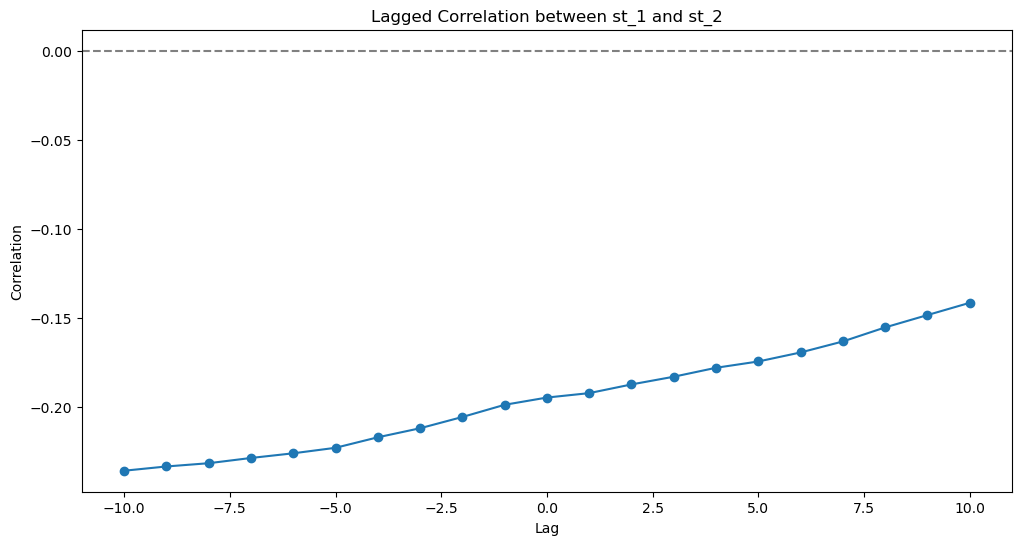

In [54]:
max_lag = 10
correlations = [st_1.corr(st_2.shift(lag)) for lag in range(-max_lag, max_lag + 1)]

plt.figure(figsize=(12, 6))
plt.plot(range(-max_lag, max_lag + 1), correlations, marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Lagged Correlation between st_1 and st_2')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

The two series are negatively correlated, and the absolute value of the correlation is close to 0. From the lagged correlation analysis graph, we can see that:

1. Negative Correlation at All Lags: The correlation remains negative across all lags, which suggests that st_1 and st_2 move in opposite directions over time.
2. Potential Mean-Reverting Relationship: Since the correlation starts at a more negative value and approaches zero, this could suggest some form of mean-reverting behavior.
3. No Strong Predictive Signal: If there was a peak or trough at a specific lag, it could indicate a strong leading relationship between the two series. However, in this case, the gradual increase suggests no clear predictive signal.

### ADF Test

In [ ]:
adf_result_st_1 = adfuller(st_1.dropna())
adf_result_st_2 = adfuller(st_2.dropna())

print(f"ADF Statistic for s1: {adf_result_st_1[0]:.4f}, p-value: {adf_result_st_1[1]:.4f}")
print(f"ADF Statistic for s2: {adf_result_st_2[0]:.4f}, p-value: {adf_result_st_2[1]:.4f}")

if adf_result_st_1[1] < 0.05:
    print("st_1 is stationary (reject null hypothesis of unit root)")
else:
    print("st_1 is not stationary (fail to reject null hypothesis of unit root)")

if adf_result_st_2[1] < 0.05:
    print("st_2 is stationary (reject null hypothesis of unit root)")
else:
    print("st_2 is not stationary (fail to reject null hypothesis of unit root)")

ADF Statistic for s1: -2.5585, p-value: 0.1019
ADF Statistic for s2: -2.9065, p-value: 0.0446
s1 is not stationary (fail to reject null hypothesis of unit root)
s2 is stationary (reject null hypothesis of unit root)


From the ADF test, we can see that st_1 is not stationary, hence if we want to make a predictive model for st_1, we should first stationalize it.

### MA Analysis

In [55]:
dt_1 = pd.DataFrame()
for n in [3, 5, 21, 63]:
    dt_1[f'dt_1_{n}'] = st_1 - st_1.rolling(n).mean()
dt_1.dropna(inplace=True)

dt_2 = pd.DataFrame()
for n in [3, 5, 21, 63]:
    dt_2[f'dt_2_{n}'] = st_2 - st_2.rolling(n).mean()
dt_2.dropna(inplace=True)

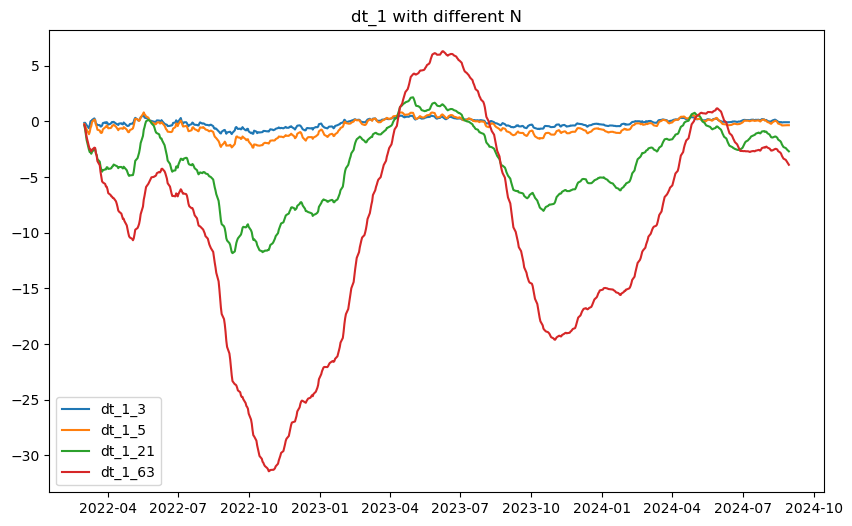

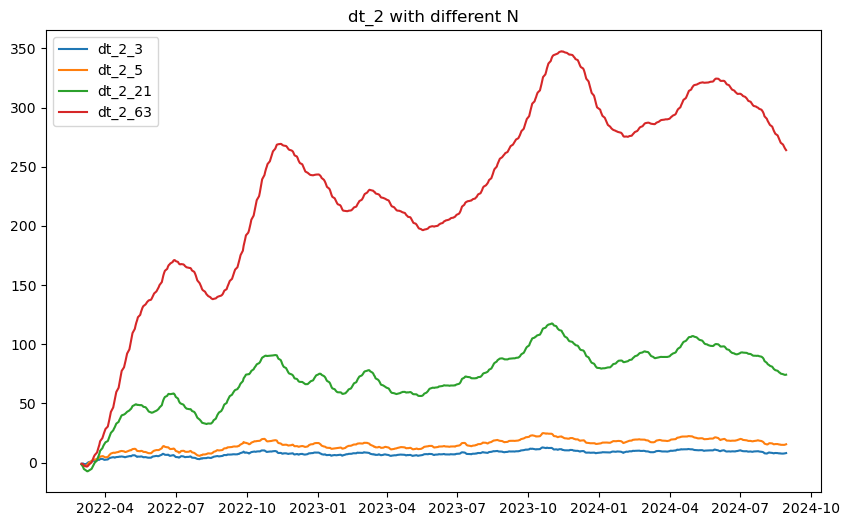

In [47]:
plt.figure(figsize=(10, 6))

for column in dt_1.columns:
    plt.plot(dt_1[column].cumsum(), label=column)
plt.title('dt_1 with different N')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for column in dt_2.columns:
    plt.plot(dt_2[column].cumsum(), label=column)
plt.title('dt_2 with different N')
plt.legend()
plt.show()

It seems that we can directly trade on dt_2 based on the graph above.

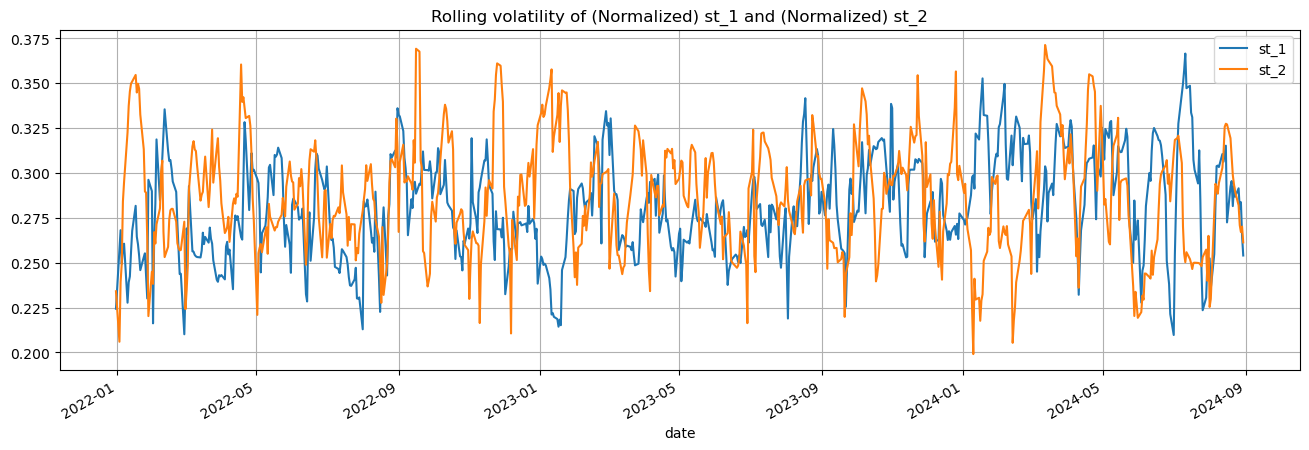

In [ ]:
scaler = MinMaxScaler()
rolling_vol = pd.DataFrame(
    {
        'st_1': merged_series['st_1'].rolling(21).apply(lambda x: (x / (x.max() - x.min())).std()),
        'st_2': merged_series['st_2'].rolling(21).apply(lambda x: (x / (x.max() - x.min())).std())
    }
)

rolling_vol.plot(figsize=(16, 5))
plt.title('Rolling volatility of (Normalized) st_1 and (Normalized) st_2')
plt.grid(True)
plt.show()

After scaling for the two series of data, we can see that their volatility seems to has not much correlation.